<a href="https://colab.research.google.com/github/surpass19/U-PIFuHD/blob/main/PIFuHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## セットアップ

In [1]:
# ライブラリー取得
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch3d

# githubからpifuhdのコードをコピー
!git clone https://github.com/facebookresearch/pifuhd

# githubからpose-estimationのコードをコピーし、学習済み重みをダウンロード
!git clone https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch.git
%cd /content/lightweight-human-pose-estimation.pytorch/
!wget https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth

# pifuhdの学習済み重みをダウンロード
%cd /content/pifuhd/
!sh ./scripts/download_trained_model.sh

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 11 kB/s 
     |████████████████████████████████| 5.9 MB 41.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
     |████████████████████████████████| 30.0 MB 1.6 MB/s 
     |█████████████████

## PIFuHDの実行

In [84]:
from IPython.display import Image,display_jpeg,display_png
# 自分の画像のアップロード（このブロックを実行しなければテスト画像を使用します）
# Google Chrome 推奨（Safariではエラーが出ます）
%cd /content/pifuhd/sample_images
from google.colab import files
filename = list(files.upload().keys())[0]
# filename = '/content/pifuhd/output.png'

/content/pifuhd/sample_images


Saving publicdomainq-0026355der-removebg-preview.png to publicdomainq-0026355der-removebg-preview.png


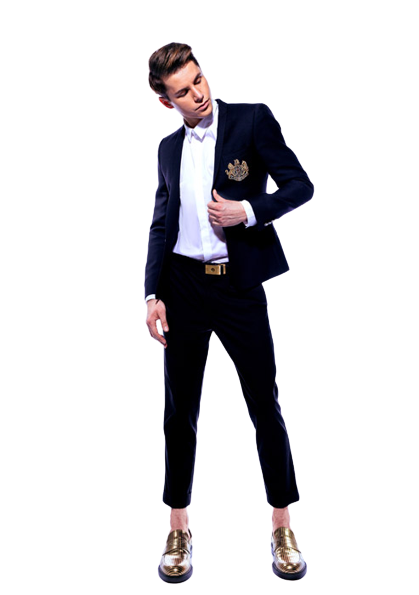

In [85]:

display_png(Image(filename))

In [86]:
filename

'publicdomainq-0026355der-removebg-preview.png'

In [87]:
image_path = '/content/pifuhd/sample_images/%s' % filename
print(image_path)

/content/pifuhd/sample_images/publicdomainq-0026355der-removebg-preview.png


In [88]:
# -*- coding:utf-8 -*-
# グレー塗りする
import cv2
import numpy as np
# 入力画像を読み込み(-1指定でαチャンネルも読み取る)
img = cv2.imread(image_path, -1)
# αチャンネルが0となるインデックスを取得
# ex) ([0, 1, 3, 3, ...],[2, 4, 55, 66, ...])
# columnとrowがそれぞれ格納されたタプル(長さ２)となっている
index = np.where(img[:, :, 3] == 0)
# 白塗りする
# img[index] = [255, 255, 255, 255]
img[index] = [113, 113, 118, 255]
# 出力
cv2.imwrite("/content/pifuhd/sample_images/put_g.png", img)


True

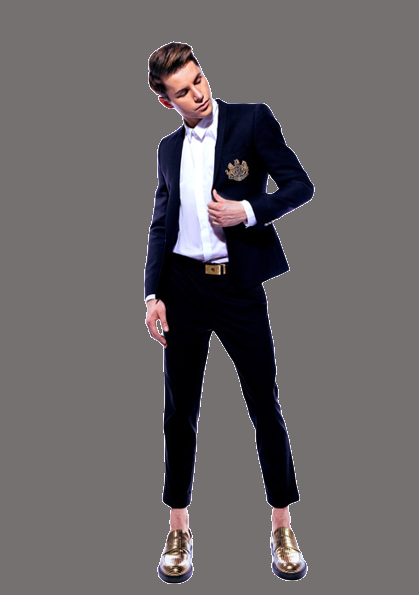

In [89]:
image_path = "/content/pifuhd/sample_images/put_g.png"
display_png(Image(image_path))

In [90]:
import cv2
#グレーの背景に埋め込む
image_path = "/content/pifuhd/sample_images/put_g.png"
fore_img = cv2.imread(image_path)
back_img = cv2.imread("/content/pifuhd/sample_images/back_gray.png")
 
dx = 100    # 横方向の移動距離
dy = 100    # 縦方向の移動距離
h, w = fore_img.shape[:2]
back_img[dy:dy+h, dx:dx+w] = fore_img
 
# cv2.imshow('img',back_img)
cv2.imwrite("/content/pifuhd/sample_images/put.png", back_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


True

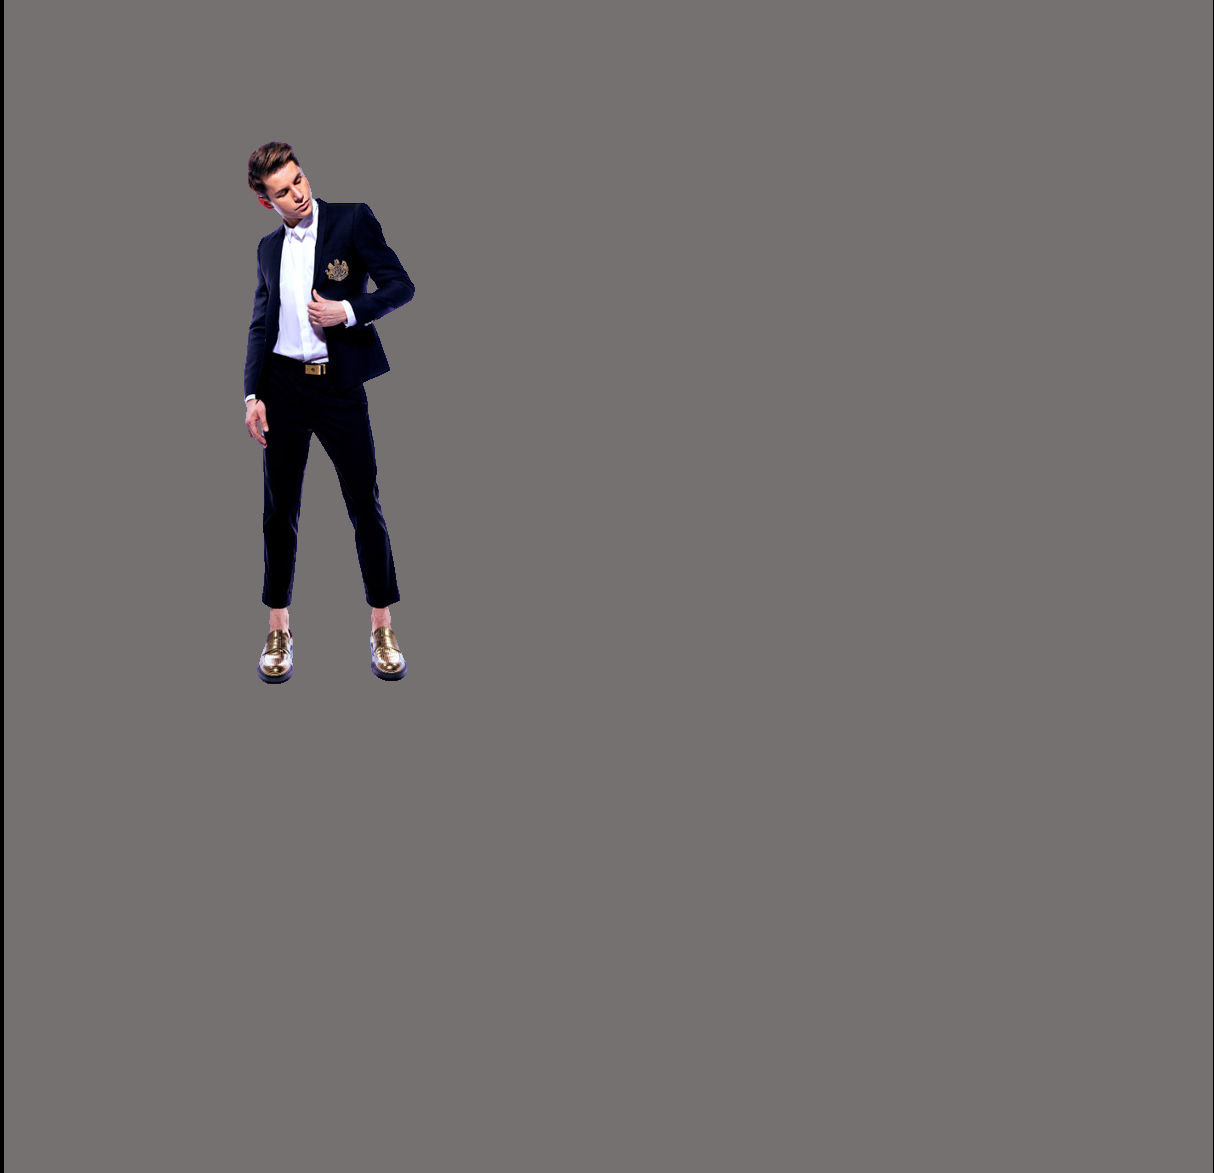

In [91]:
image_path = "/content/pifuhd/sample_images/put.png"
display_png(Image(image_path))

In [92]:
# セッティング
import os

try:
  # image_path = '/content/pifuhd/sample_images/%s' % filename
  image_path = '/content/pifuhd/sample_images/put.png'
except:
  image_path = '/content/pifuhd/sample_images/test.png' # example image
image_dir = os.path.dirname(image_path)
file_name = os.path.splitext(os.path.basename(image_path))[0]

# output pathes
obj_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.obj' % file_name
out_img_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.png' % file_name
video_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.mp4' % file_name
video_display_path = '/content/pifuhd/results/pifuhd_final/result_%s_256_display.mp4' % file_name

In [93]:
image_path

'/content/pifuhd/sample_images/put.png'

In [94]:
out_img_path

'/content/pifuhd/results/pifuhd_final/recon/result_put_256.png'

In [95]:
# クロッピング
%cd /content/lightweight-human-pose-estimation.pytorch/
import torch
import cv2
import numpy as np
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
import demo

def get_rect(net, images, height_size):
    net = net.eval()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for image in images:
        rect_path = image.replace('.%s' % (image.split('.')[-1]), '_rect.txt')
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        orig_img = img.copy()
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = demo.infer_fast(net, img, height_size, stride, upsample_ratio, cpu=False)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []

        rects = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            valid_keypoints = []
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
                    valid_keypoints.append([pose_keypoints[kpt_id, 0], pose_keypoints[kpt_id, 1]])
            valid_keypoints = np.array(valid_keypoints)
            
            if pose_entries[n][10] != -1.0 or pose_entries[n][13] != -1.0:
              pmin = valid_keypoints.min(0)
              pmax = valid_keypoints.max(0)

              center = (0.5 * (pmax[:2] + pmin[:2])).astype(int)
              radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))
            elif pose_entries[n][10] == -1.0 and pose_entries[n][13] == -1.0 and pose_entries[n][8] != -1.0 and pose_entries[n][11] != -1.0:
              # if leg is missing, use pelvis to get cropping
              center = (0.5 * (pose_keypoints[8] + pose_keypoints[11])).astype(int)
              radius = int(1.45*np.sqrt(((center[None,:] - valid_keypoints)**2).sum(1)).max(0))
              center[1] += int(0.05*radius)
            else:
              center = np.array([img.shape[1]//2,img.shape[0]//2])
              radius = max(img.shape[1]//2,img.shape[0]//2)

            x1 = center[0] - radius
            y1 = center[1] - radius

            rects.append([x1, y1, 2*radius, 2*radius])

        np.savetxt(rect_path, np.array(rects), fmt='%d')

net = PoseEstimationWithMobileNet()
checkpoint = torch.load('checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)

get_rect(net.cuda(), [image_path], 512)

/content/lightweight-human-pose-estimation.pytorch


In [96]:
# レンダリング
%cd /content/pifuhd/
!python -m apps.simple_test -r 256 --use_rect -i $image_dir

/content/pifuhd
Resuming from  ./checkpoints/pifuhd.pt
test data size:  1
initialize network with normal
initialize network with normal
generate mesh (test) ...
  0% 0/1 [00:00<?, ?it/s]./results/pifuhd_final/recon/result_put_256.obj
/content/pifuhd/lib/mesh_util.py:77: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = measure.marching_cubes_lewiner(sdf, thresh)
100% 1/1 [00:09<00:00,  9.35s/it]


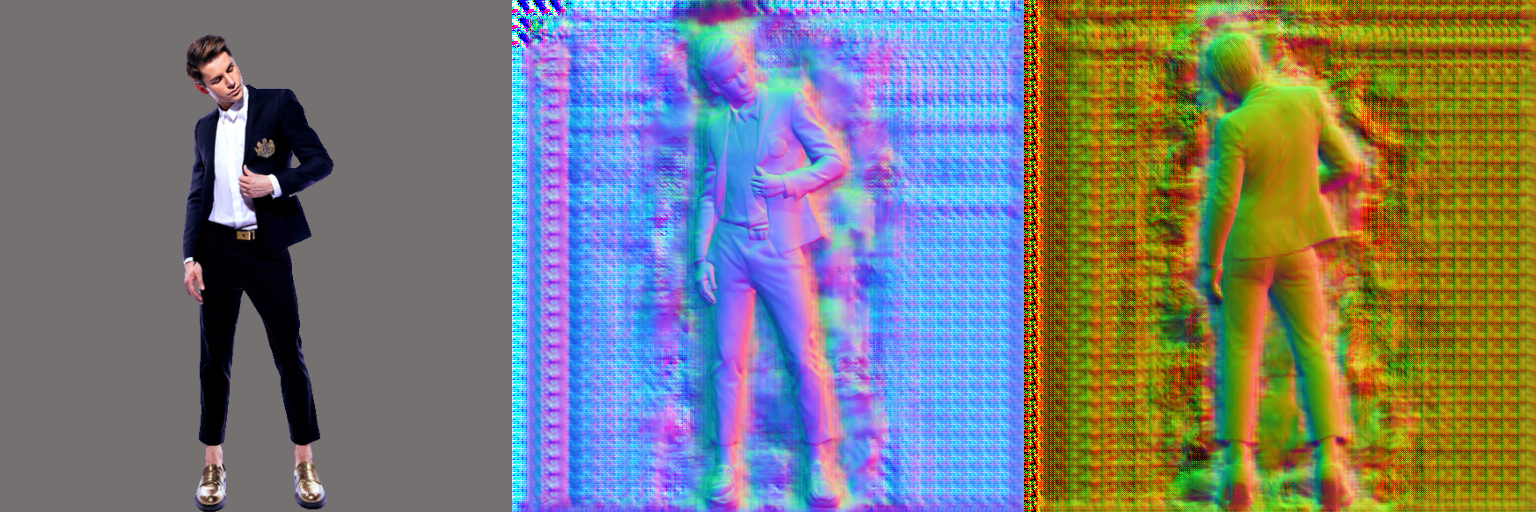

In [97]:
display_png(Image('/content/pifuhd/results/pifuhd_final/recon/result_put_256.png'))

In [98]:
# mp4の作成
from lib.colab_util import generate_video_from_obj, set_renderer, video

renderer = set_renderer()
generate_video_from_obj(obj_path, out_img_path, video_path, renderer)

# we cannot play a mp4 video generated by cv2
!ffmpeg -i $video_path -vcodec libx264 $video_display_path -y -loglevel quiet
video(video_display_path)

  0%|          | 0/90 [00:00<?, ?it/s]